In [1]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

In [2]:
EPOCHS = 200
LEARNING_RATE = 0.005
BATCH_SIZE = 2


## Dataset

In [3]:
from utils import ImageGenerationDataset
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler

In [4]:
train_dataset = ImageGenerationDataset('data/train')
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = ImageGenerationDataset('data/test')

In [5]:
normalizers = []

In [6]:
scaled_X_train = torch.zeros_like(train_dataset.X)
scaled_X_test = torch.zeros_like(test_dataset.X)

for channel in range(0, 4):
    normalizer = StandardScaler()
    normalizer.fit(train_dataset.X[:, channel, :])

    scaled_X_train[:, channel, :] = torch.from_numpy(normalizer.transform(train_dataset.X[:, channel, :]))
    scaled_X_test [:, channel, :] = torch.from_numpy(normalizer.transform(test_dataset.X[:, channel, :]))

train_dataset.X = scaled_X_train
test_dataset.X = scaled_X_test

    

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Training

In [8]:
from net import ImageGenerator

### Objects

In [9]:
model = ImageGenerator()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE,momentum=0.9)
loss_fn = torch.nn.L1Loss()

### Training Loop

In [10]:
model.train(True)

loss_lst = []
valid_loss_lst = []
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    model.train()
    seq = 0
    for i, (features, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()

        features = features.float()
        targets = targets.float()
        
        outputs = model(features)

        loss = loss_fn(outputs, targets)
        loss.backward()

        epoch_loss += loss.item()
        optimizer.step()

        seq += features.shape[0]
    loss_lst.append(epoch_loss / seq)
    model.eval()
    validation_loss = 0.0
    seq = 0
    for i, (features, targets) in enumerate(test_dataloader):
        features = features.float()
        targets = targets.float()
        
        outputs = model(features)
        loss = loss_fn(outputs, targets)
        validation_loss += loss.item()
        seq += features.shape[0]
    if (epoch + 1) % 10 == 0:
        print('Epoch', epoch)
        print("In-sample Loss:", epoch_loss)
        print("Validation Loss: ", validation_loss)
    valid_loss_lst.append(validation_loss / seq)
    
    
    

c:\Users\Taylor\Desktop\Projects\BCI\GitHub Projects\bci-image-generation\venv\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([2, 32, 32])) that is different to the input size (torch.Size([2, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 9
In-sample Loss: 10.249525435268879
Validation Loss:  1.835259035229683
Epoch 19
In-sample Loss: 10.105073645710945
Validation Loss:  1.8231199607253075
Epoch 29
In-sample Loss: 10.03059259802103
Validation Loss:  1.8264147862792015
Epoch 39
In-sample Loss: 9.973966211080551
Validation Loss:  1.8340523838996887
Epoch 49
In-sample Loss: 9.828276723623276
Validation Loss:  1.838813729584217
Epoch 59
In-sample Loss: 9.768054500222206
Validation Loss:  1.8597441166639328
Epoch 69
In-sample Loss: 9.685322053730488
Validation Loss:  1.8394984379410744
Epoch 79
In-sample Loss: 9.520643278956413
Validation Loss:  1.8756857067346573
Epoch 89
In-sample Loss: 9.531157076358795
Validation Loss:  1.8881105035543442
Epoch 99
In-sample Loss: 9.130962580442429
Validation Loss:  1.911018431186676
Epoch 109
In-sample Loss: 9.314307913184166
Validation Loss:  1.874701701104641
Epoch 119
In-sample Loss: 9.376854747533798
Validation Loss:  1.9860739558935165
Epoch 129
In-sample Loss: 9.2424315363168

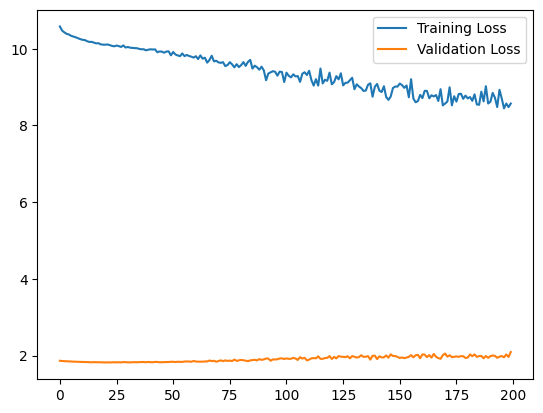

In [11]:
plt.plot(loss_lst)
plt.plot(valid_loss_lst) 
plt.legend(['Training Loss', 'Validation Loss'], )

In [12]:
import torchvision.transforms as transforms
from PIL import Image

In [13]:
# https://note.nkmk.me/en/python-pillow-concat-images/
def get_concat_h(im1, im2):
    dst = Image.new('L', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('L', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

In [14]:
PIL_transform = transforms.ToPILImage()

In [15]:
train_true_images = None
train_output_images = None

for train_f, train_t in train_dataloader:
    train_f = train_f.float()
    output = model(train_f)

    for b in range(output.shape[0]):
        output_img = output[b]
        output_img = PIL_transform(output_img)

        true_img = train_t[b]
        true_img = PIL_transform(true_img)

        if train_true_images is None and train_output_images is None:
            train_true_images = true_img
            train_output_images = output_img
        else:
            train_true_images = get_concat_h(train_true_images, true_img)
            train_output_images = get_concat_h(train_output_images, output_img)
train_images = get_concat_v(train_true_images, train_output_images)




In [16]:
test_true_images = None
test_output_images = None

for test_f, test_t in test_dataloader:
    test_f = test_f.float()
    output = model(test_f)

    for b in range(output.shape[0]):
        output_img = output[b]
        output_img = PIL_transform(output_img)

        test_img = test_t[b]
        test_img = PIL_transform(test_img)

        if test_true_images is None and test_output_images is None:
            test_true_images = test_img
            test_output_images = output_img
        else:
            test_true_images = get_concat_h(test_true_images, test_img)
            test_output_images = get_concat_h(test_output_images, output_img)
test_images = get_concat_v(test_true_images, test_output_images)


In [17]:
train_images.show()
test_images.show()

In [18]:
print('Completed.')

Completed.
